In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Categorical data
Categorical variables represent the type of data that are labeled and divided into groups. Examples include race, gender, college major, political preference, coin tossing outcome (heads or tails), etc. 

Testing for two-sample differences in categorical data can be done using the same procedures we introduced for numerical observations. The main difference is in the choice of test statistic and we illustrate it below with data from the [2022 General Social Survey](https://gss.norc.org/). 

In [3]:
gss=pd.read_csv("../../data/gss.csv")
gss

,Sex,Strong democrat,Not very strong democrat,"Independent, close to democrat","Independent (neither, no response)","Independent, close to republican",Not very strong republican,Strong republican,Other party
0,MALE,198,197,169,366,256,206,222,76
1,FEMALE,320,264,181,409,162,174,225,39


The table above shows the number of subjects by gender and party identification (for example, there are 198 subjects who identify as "Male" and "Strong democrat". The goal of the analysis is to investigate if there are differences in party identification between males and females. As you can see below, there are 1690 males and 1774 females in this dataset.

In [6]:
gss.drop(columns=["Sex"]).sum(axis=1)

0    1690
1    1774
dtype: int64

To test if males and females have the same party identification distributions, we need to set up the components of a hypothesis test:

- Null hypothesis, $H_0$ - the proportion of males and females in each party category in the US population are the same.
- Alternative hypothesis, $H_A$ - there is at least one category for which the proportions are different.
- Test statistic - because we are interested in finding differences in proportions, it is natural to consider functions of these differences, such as **Total variation distance (TVD)** introduced below.

TVD is defined as the sum of absolute differences in proportions:

$${\rm TVD}=\frac{1}{2} \sum |p_i-q_i|$$

In the above formula, $p_i$'s are proportions of subjects in various categories (e.g. party identification) in one sample (e.g., males) while $q_i$'s are proportions in the second sample (e.g., females). 

A function that calculates the total variation distance for two arrays of counts is implemented below. 

In [12]:
def tvd(array1,array2): 
    """ Total variation distance for proportions from two arrays of counts"""
    return sum(abs(array1/sum(array1)-array2/sum(array2)))/2

obs_TVD=tvd(gss.drop(columns=["Sex"]).iloc[0].values,
          gss.drop(columns=["Sex"]).iloc[1].values)

print(obs_TVD)

0.11148542724295041


For our data, TVD between males and females is equal to 0.11. Next, we will determine if this value is consistent with our null hypothesis.

Note that the data is in aggregated form. To implement the permutation procedure, we need to first create a DataFrame that has 1690+1774=3464 rows, with each row corresponding to one participant in the study. The DataFrame will capture information on sex and party preference. A sample of 5 rows in the new data frame is displayed.

In [14]:
# arrays of the categories in the two variables
sex=gss.Sex.values
party=gss.drop(columns=["Sex"]).columns.values

# start with an empty dataframe
gss_full=pd.DataFrame()

# for each count in the `gss` data frame, add a corresponding number of rows 
for i in sex:
    for j in party:
        nr_sub=gss[gss.Sex==i][[j]].values.item()
        df=pd.DataFrame([list([i,j])],index=range(nr_sub),columns=list(["Sex","Party"]))
        gss_full=pd.concat([gss_full,df])

gss_full.sample(5)

,Sex,Party
18,FEMALE,"Independent, close to democrat"
77,MALE,"Independent, close to democrat"
96,FEMALE,Not very strong democrat
110,FEMALE,Strong republican
237,FEMALE,Not very strong democrat


Note that we can calculate the number of subjects in each group using `groupby`, and from this summary we can calculate TVD.

In [64]:
tmp=gss_full.groupby(["Sex","Party"]).size().reset_index(name="n_subjects")
tmp

,Sex,Party,n_subjects
0,FEMALE,"Independent (neither, no response)",409
1,FEMALE,"Independent, close to democrat",181
2,FEMALE,"Independent, close to republican",162
3,FEMALE,Not very strong democrat,264
4,FEMALE,Not very strong republican,174
5,FEMALE,Other party,39
6,FEMALE,Strong democrat,320
7,FEMALE,Strong republican,225
8,MALE,"Independent (neither, no response)",366
9,MALE,"Independent, close to democrat",169


In [74]:
# create separate arrays for Female and Male 
female_n = tmp[tmp['Sex']=="FEMALE"]['n_subjects'].values
male_n = tmp[tmp['Sex']=="MALE"]['n_subjects'].values

# calculate TVD
tvd(female_n,male_n)

0.11148542724295042

Above, we illustrated that our procedure for constructing  the sampling frame (the raw dataset) is correct - we obtained the same test statistic from the complete data table as the one we obtained from the summary data.

We are ready now to simulate under the null hypothesis using permutations.

In [87]:
# the array where simulated TVDs will be stored
sim_tvd=np.array([])

# the number of simulations 
nr_sim=1000

for i in np.arange(nr_sim):
    gss_full_copy=gss_full
    gss_full_copy['Party']=np.random.permutation(gss_full_copy['Party'])
    tmp=gss_full_copy.groupby(["Sex","Party"]).size().reset_index(name="n_subjects")
    female_n = tmp[tmp['Sex']=="FEMALE"]['n_subjects'].values
    male_n = tmp[tmp['Sex']=="MALE"]['n_subjects'].values
    sim_tvd=np.append(sim_tvd,tvd(female_n,male_n))

The simulation results are saved in an array, `sim_tvd`, of length 1,000. We created 1,000 shuffled datasets and for each we calculated the corresponding TVD value. The histogram below shows that there is strong evidence against the null hypothesis that male and female had the same distribution of political differences.

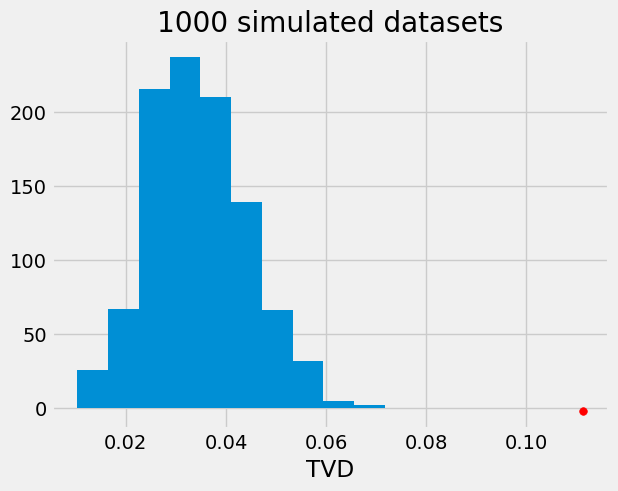

In [89]:
plt.hist(sim_tvd)
plt.scatter(obs_TVD, -2, color='red', s=30)
plt.title('1000 simulated datasets')
plt.xlabel("TVD");